# Customer Segmentation for E-commerce Personalization


# The dataset 
This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

Additional Information

InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation. 
StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.
Description: Product (item) name. Nominal.
Quantity: The quantities of each product (item) per transaction. Numeric.	
InvoiceDate: Invice Date and time. Numeric, the day and time when each transaction was generated.
UnitPrice: Unit price. Numeric, Product price per unit in sterling.
CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
Country: Country name. Nominal, the name of the country where each customer resides. 



# Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
import seaborn as sns
import plotly.express as px
from math import pi


# Reading Data

In [2]:
data = pd.read_excel('Online Retail.xlsx', engine='openpyxl')

In [3]:
data.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom

In [32]:
data.tail()

InvoiceNo StockCode                      Description  Quantity  \
541904    581587     22613      PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899     CHILDREN'S APRON DOLLY GIRL          6   
541906    581587     23254    CHILDRENS CUTLERY DOLLY GIRL          4   
541907    581587     23255  CHILDRENS CUTLERY CIRCUS PARADE         4   
541908    581587     22138    BAKING SET 9 PIECE RETROSPOT          3   

               InvoiceDate  UnitPrice CustomerID Country  TotalSales  \
541904 2011-12-09 12:50:00       0.85    12680.0  France       10.20   
541905 2011-12-09 12:50:00       2.10    12680.0  France       12.60   
541906 2011-12-09 12:50:00       4.15    12680.0  France       16.60   
541907 2011-12-09 12:50:00       4.15    12680.0  France       16.60   
541908 2011-12-09 12:50:00       4.95    12680.0  France       14.85   

       DayOfWeek     Month  
541904    Friday  December  
541905    Friday  December  
541906    Friday  December  
541907    Friday  December  
541908    Friday  December

# Data Exploration and EDA

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [5]:
data.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

In [6]:
data.shape

(541909, 8)

In [7]:
data.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [8]:
data.duplicated().sum()

5268

In [9]:
data.drop_duplicates(inplace=True)

In [10]:
data.shape

(536641, 8)

In [11]:
data['Quantity'].min()

-80995

In [12]:
data['Quantity'].max()

80995

In [13]:
#The negative values could represent refunds
data['UnitPrice'].min()

-11062.06

In [14]:
data['UnitPrice'].max()

38970.0

In [15]:
num_unique_countries = data['Country'].nunique()
print(num_unique_countries)


38


# Time Series Analysis of Sales:
Ploting the total sales (Quantity * UnitPrice) over time (InvoiceDate). This will give insights into sales trends and seasonality.

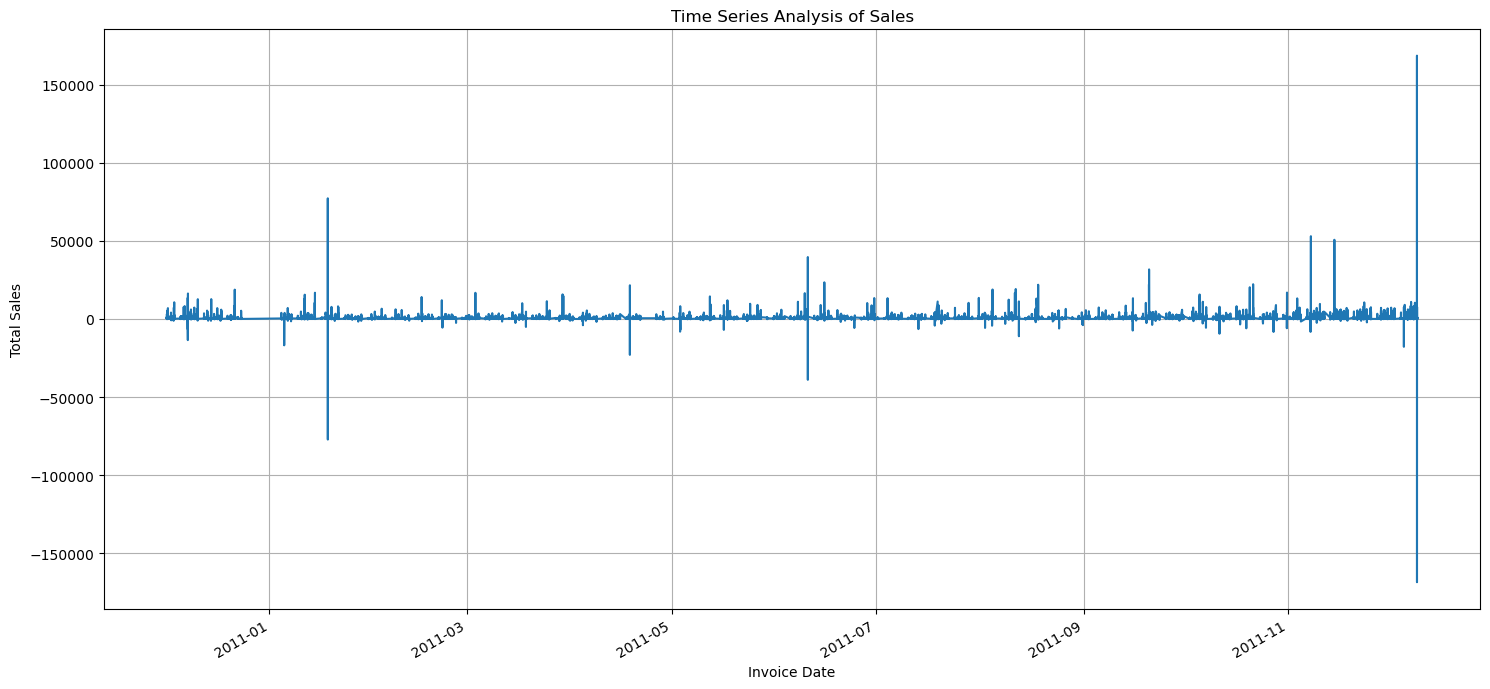

In [16]:
# Convert InvoiceDate to datetime format
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

# Calculate total sales
data['TotalSales'] = data['Quantity'] * data['UnitPrice']

# Group by InvoiceDate and sum the total sales
time_series_sales = data.groupby('InvoiceDate')['TotalSales'].sum()

# Plotting
plt.figure(figsize=(15, 7))
time_series_sales.plot()
plt.title('Time Series Analysis of Sales')
plt.ylabel('Total Sales')
plt.xlabel('Invoice Date')
plt.grid(True)
plt.tight_layout()
plt.show()


Filter out Cancellations:
InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.

In [17]:
cancellations = data[data['InvoiceNo'].astype(str).str.startswith('C')]


In [18]:
num_cancellations = len(cancellations)
print(f"There are {num_cancellations} cancellations.")


There are 9251 cancellations.


In [19]:
cancellation_counts = cancellations['StockCode'].value_counts()
cancellation_counts

M         244
22423     180
POST      126
22960      87
D          77
         ... 
22977       1
85068       1
85024C      1
85025C      1
23843       1
Name: StockCode, Length: 1947, dtype: int64

Top Selling Products:
Group by StockCode and sum Quantity to identify the top-selling products, and a pie chart shows the results.

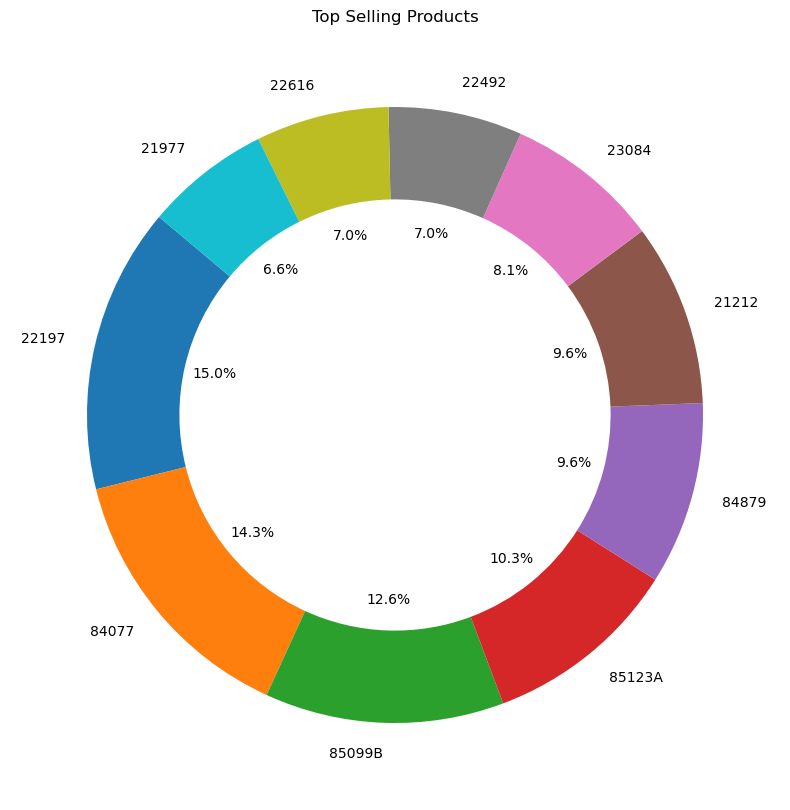

In [20]:

# Group by StockCode and sum the Quantity
top_products = data.groupby('StockCode').agg({'Quantity': 'sum'}).reset_index()

# Sort by Quantity in descending order and take top n
top_n = 10
top_products = top_products.sort_values(by='Quantity', ascending=False).head(top_n)

# Plotting pie chart
plt.figure(figsize=(10, 10))
plt.pie(top_products['Quantity'], labels=top_products['StockCode'], autopct='%1.1f%%', startangle=140, wedgeprops=dict(width=0.3))
plt.title('Top Selling Products')
plt.show()


Sales Distribution by Country:
Group by Country and sum the total sales to see the distribution of sales by country. A bar chart shows the results.

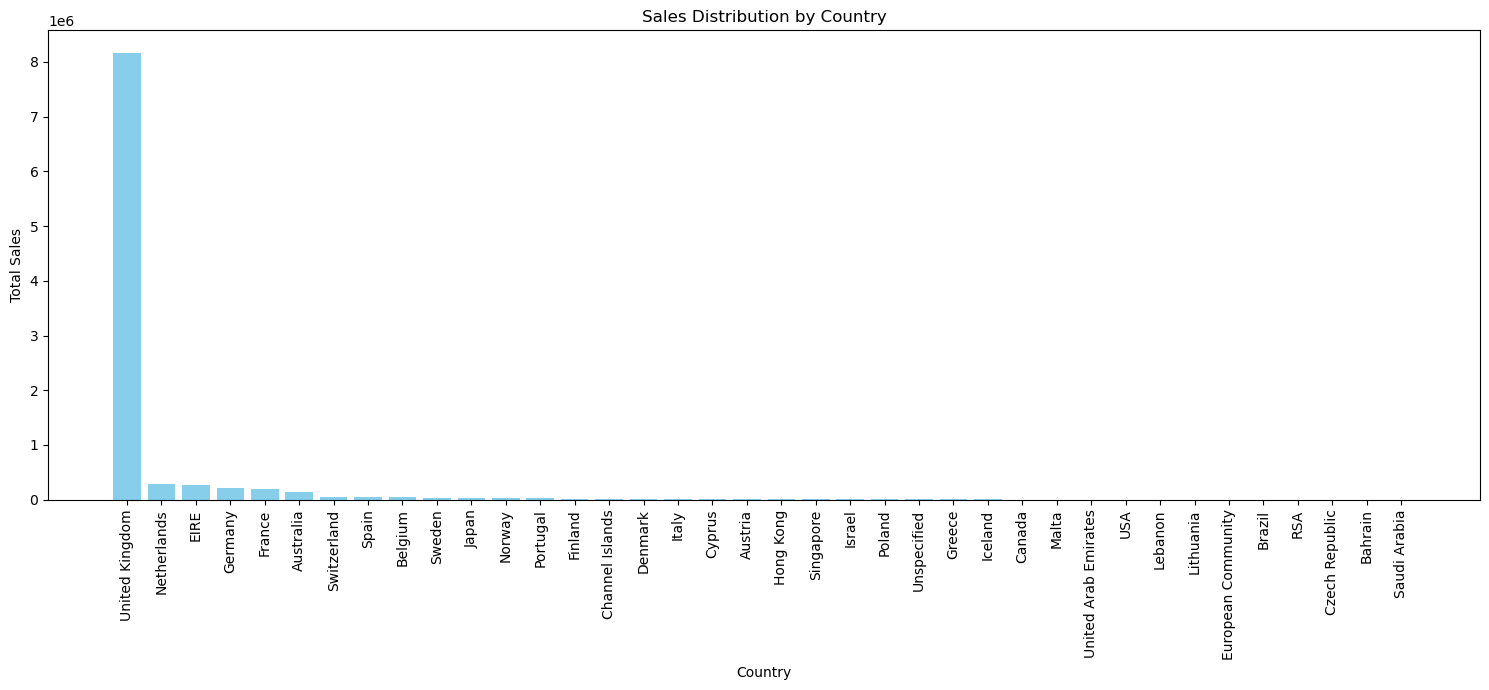

In [21]:

# Compute total sales for each transaction
data['TotalSales'] = data['Quantity'] * data['UnitPrice']

# Group by Country and sum the total sales
sales_by_country = data.groupby('Country').agg({'TotalSales': 'sum'}).reset_index()

# Sort values for better visualization
sales_by_country = sales_by_country.sort_values(by='TotalSales', ascending=False)

# Plotting bar chart
plt.figure(figsize=(15, 7))
plt.bar(sales_by_country['Country'], sales_by_country['TotalSales'], color='skyblue')
plt.title('Sales Distribution by Country')
plt.xlabel('Country')
plt.ylabel('Total Sales')
plt.xticks(rotation=90)  # Rotate country names for better visibility
plt.tight_layout()
plt.show()


Sales Volume Distribution:
A histogram of Quantity to see the distribution of sales volumes. This can help in understanding the most common sales quantities.

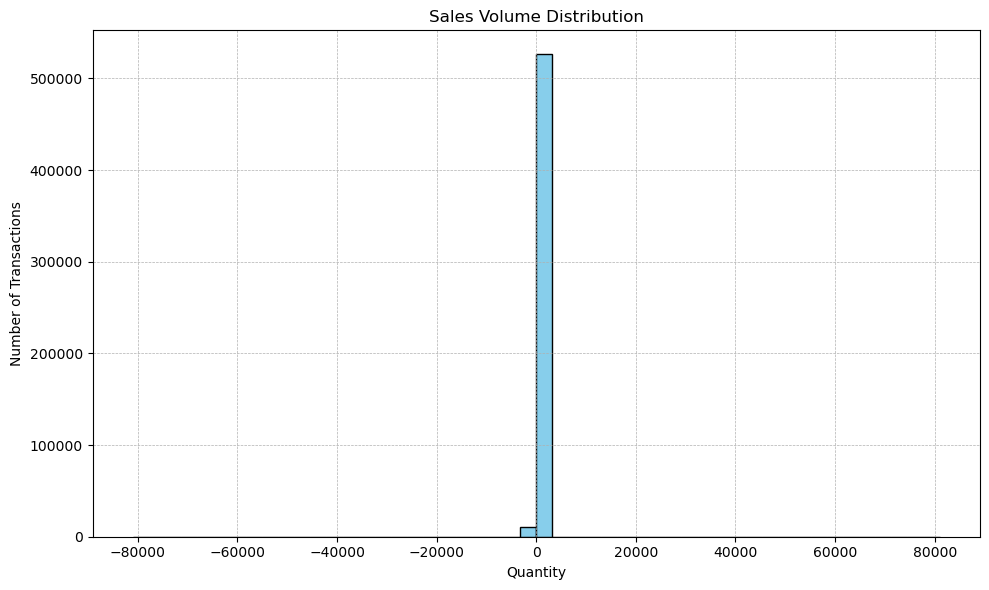

In [22]:
# Plotting histogram
plt.figure(figsize=(10, 6))
plt.hist(data['Quantity'], bins=50, color='skyblue', edgecolor='black') 
plt.title('Sales Volume Distribution')
plt.xlabel('Quantity')
plt.ylabel('Number of Transactions')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


Unit Price Distribution:
A histogram or box plot of UnitPrice to visualize the distribution of product prices.

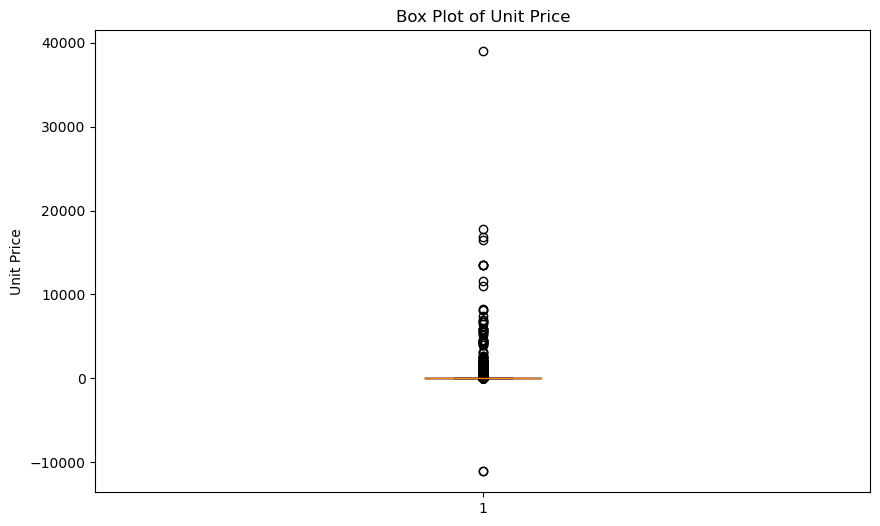

In [23]:
plt.figure(figsize=(10, 6))
plt.boxplot(data['UnitPrice'])
plt.title('Box Plot of Unit Price')
plt.ylabel('Unit Price')
plt.show()


analyze sales by the day of the week or month

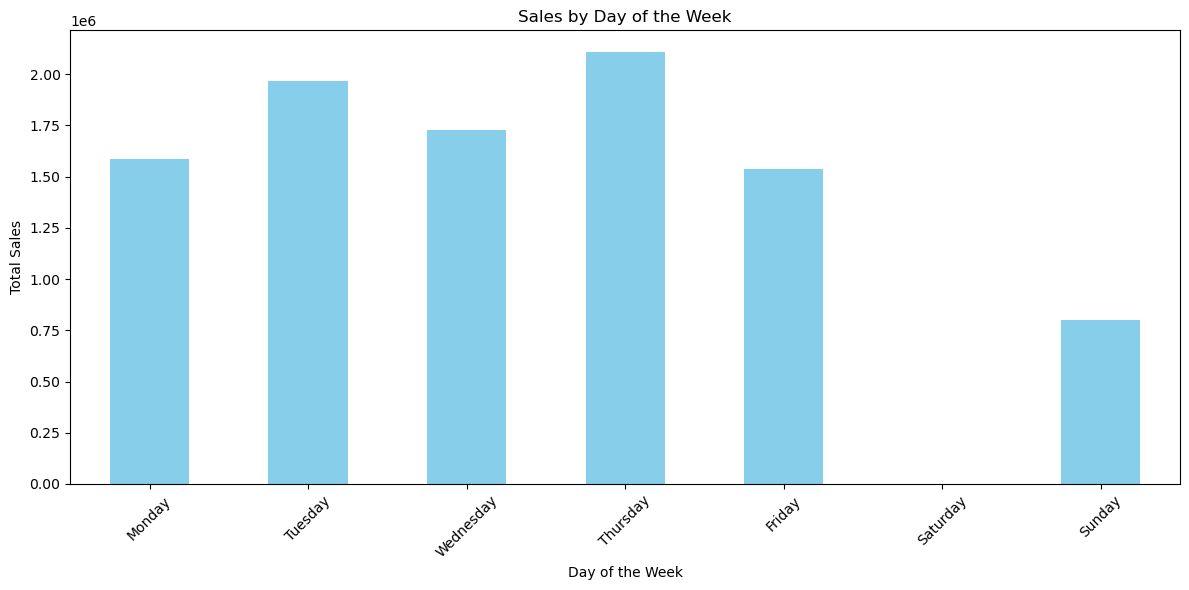

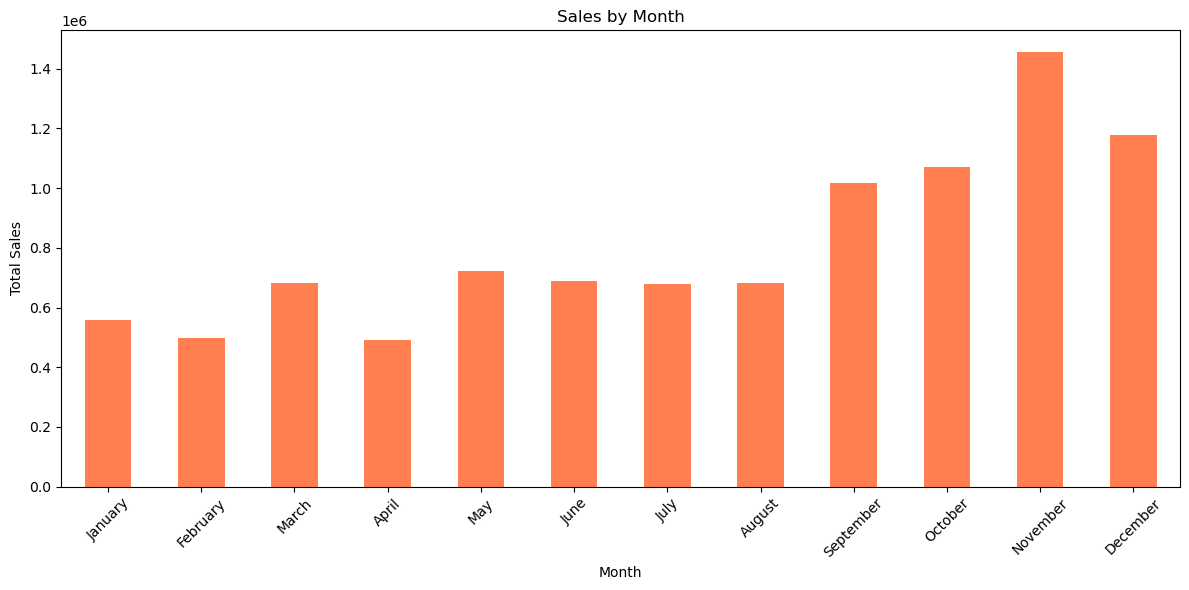

In [24]:

# Convert InvoiceDate to datetime format
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

# Extract day of the week and month
data['DayOfWeek'] = data['InvoiceDate'].dt.day_name()
data['Month'] = data['InvoiceDate'].dt.month_name()

# Compute total sales for each row
data['TotalSales'] = data['Quantity'] * data['UnitPrice']

# Aggregate sales by day of the week
sales_by_day = data.groupby('DayOfWeek').agg({'TotalSales': 'sum'}).reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

# Plotting sales by day of the week
plt.figure(figsize=(12, 6))
sales_by_day['TotalSales'].plot(kind='bar', color='skyblue')
plt.title('Sales by Day of the Week')
plt.ylabel('Total Sales')
plt.xlabel('Day of the Week')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Aggregate sales by month
sales_by_month = data.groupby('Month').agg({'TotalSales': 'sum'}).reindex(['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])

# Plotting sales by month
plt.figure(figsize=(12, 6))
sales_by_month['TotalSales'].plot(kind='bar', color='coral')
plt.title('Sales by Month')
plt.ylabel('Total Sales')
plt.xlabel('Month')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Country-wise Heat Map:
A heat map displaying sales by country.

In [25]:
# Compute total sales for each country
country_sales = data.groupby('Country').agg({'TotalSales': 'sum'}).reset_index()

# Plotting using plotly
fig = px.choropleth(country_sales, 
                    locations="Country", 
                    locationmode = "country names",
                    color="TotalSales",
                    hover_name="Country",
                    color_continuous_scale=px.colors.sequential.Plasma)

fig.update_geos(projection_type="orthographic")
fig.update_layout(title='Country-wise Sales Distribution')
fig.show()


Top Customers:
Group by InvoiceNo to get total sales per transaction, then identify top customers based on frequency or value of transactions.

In [26]:
# Replace NaN values in CustomerID with 'Unknown'
data['CustomerID'].fillna('Unknown', inplace=True)


In [27]:
# Order Frequency
order_frequency = data['InvoiceNo'].nunique()

print(f"Total number of unique orders (Order Frequency): {order_frequency}")


Total number of unique orders (Order Frequency): 25900


In [28]:
# Calculate total sales for each row
data['TotalSales'] = data['Quantity'] * data['UnitPrice']

# Aggregate data by CustomerID
customer_data = data.groupby('CustomerID').agg({
    'InvoiceNo': 'nunique',     # Count unique invoices per customer to get frequency
    'TotalSales': 'sum'         # Sum total sales per customer to get value
}).reset_index()

# Rename columns for clarity
customer_data.rename(columns={'InvoiceNo': 'NumOfPurchases', 'TotalSales': 'TotalSpent'}, inplace=True)

# Sort by total spent to get top customers by value
top_customers_by_value = customer_data.sort_values(by='TotalSpent', ascending=False)

# Sort by number of purchases to get top customers by frequency
top_customers_by_frequency = customer_data.sort_values(by='NumOfPurchases', ascending=False)

# Display the top 5 customers
print('Top_customers by value')
print(top_customers_by_value.head(5))
print('Top_customers by frequency')
print(top_customers_by_frequency.head(5))


Top_customers by value
     CustomerID  NumOfPurchases  TotalSpent
4372    Unknown            3710  1447487.53
1703    14646.0              77   279489.02
4233    18102.0              62   256438.49
3758    17450.0              55   187322.17
1895    14911.0             248   132458.73
Top_customers by frequency
     CustomerID  NumOfPurchases  TotalSpent
4372    Unknown            3710  1447487.53
1895    14911.0             248   132458.73
330     12748.0             224    28405.56
4042    17841.0             169    39869.05
1674    14606.0             128    11633.35


<Figure size 1000x500 with 0 Axes>

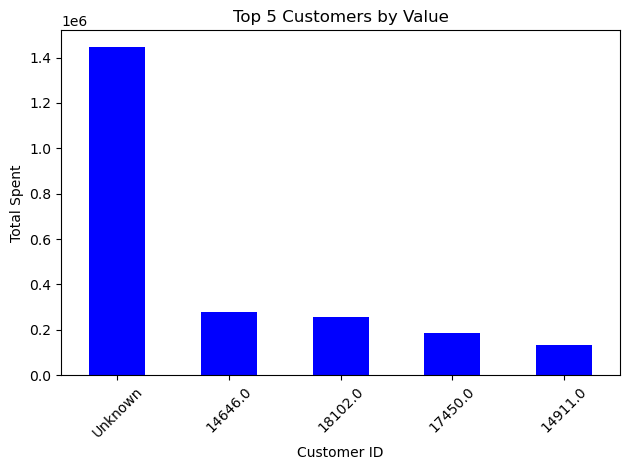

<Figure size 1000x500 with 0 Axes>

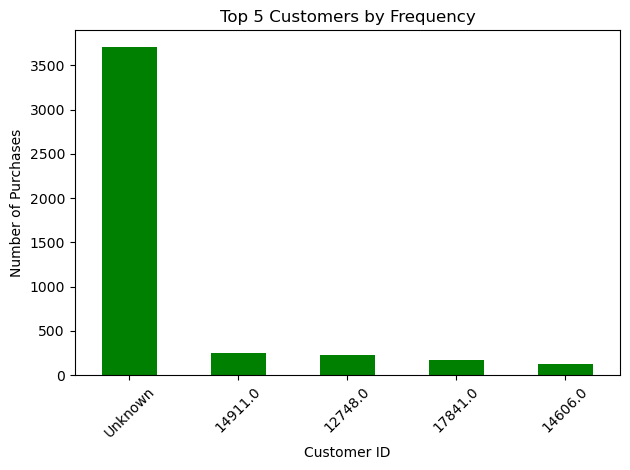

In [29]:
# Plotting top 5 customers by value
plt.figure(figsize=(10, 5))
top_customers_by_value.head(5).plot(x='CustomerID', y='TotalSpent', kind='bar', legend=False, color='blue')
plt.title('Top 5 Customers by Value')
plt.ylabel('Total Spent')
plt.xlabel('Customer ID')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plotting top 5 customers by frequency
plt.figure(figsize=(10, 5))
top_customers_by_frequency.head(5).plot(x='CustomerID', y='NumOfPurchases', kind='bar', legend=False, color='green')
plt.title('Top 5 Customers by Frequency')
plt.ylabel('Number of Purchases')
plt.xlabel('Customer ID')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Purchase History

In [30]:
# Aggregate data to list out items for each invoice of every customer
purchase_history = data.groupby(['CustomerID', 'InvoiceNo']).agg({
    'StockCode': list,        # List of items in each invoice
    'InvoiceDate': 'first',   # Invoice date
    'TotalSales': 'sum'       # Total sales value for each invoice
}).reset_index()

# Sorting by date for better representation
purchase_history.sort_values(by=['CustomerID', 'InvoiceDate'], inplace=True)


In [33]:
customer_id = 12680.0  
specific_customer_history = purchase_history[purchase_history['CustomerID'] == customer_id]
print(specific_customer_history)


     CustomerID InvoiceNo                                          StockCode  \
1274    12680.0    563712  [21981, 21986, 22037, 23190, 22555, 22629, 229...   
1275    12680.0    566256   [22730, 22726, 20682, 37495, 21208, 20751, POST]   
1276    12680.0    568518  [22555, 22556, 22630, 22629, 22634, 22635, 227...   
1277    12680.0    581587  [22631, 22556, 22555, 22728, 22727, 22726, 227...   

             InvoiceDate  TotalSales  
1274 2011-08-18 15:44:00      311.78  
1275 2011-09-11 12:27:00      112.38  
1276 2011-09-27 12:53:00      189.20  
1277 2011-12-09 12:50:00      249.45  


Total Spending 

In [34]:
print(purchase_history.head())


  CustomerID InvoiceNo                                          StockCode  \
0    12346.0    541431                                            [23166]   
1    12346.0   C541433                                            [23166]   
2    12347.0    537626  [85116, 22375, 71477, 22492, 22771, 22772, 227...   
3    12347.0    542237  [84625A, 84625C, 85116, 20719, 22375, 22376, 2...   
4    12347.0    549222  [22376, 22374, 22371, 22375, 20665, 23076, 217...   

          InvoiceDate  TotalSales  
0 2011-01-18 10:01:00    77183.60  
1 2011-01-18 10:17:00   -77183.60  
2 2010-12-07 14:57:00      711.79  
3 2011-01-26 14:30:00      475.39  
4 2011-04-07 10:43:00      636.25  


In [31]:
# Aggregate data by 'CustomerID' and sum the 'TotalSales'
total_spending = data.groupby('CustomerID')['TotalSales'].sum().reset_index()

# Sort customers by their total spending
total_spending_sorted = total_spending.sort_values(by='TotalSales', ascending=False)


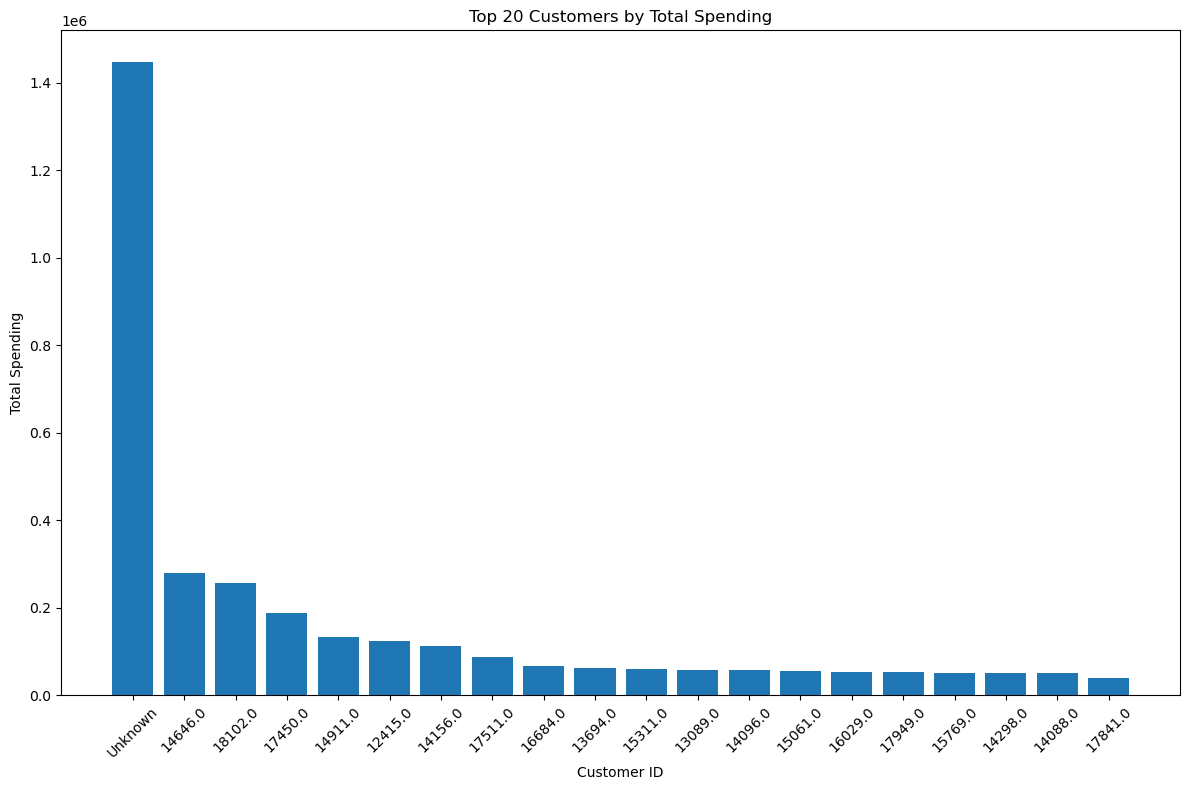

In [37]:

top_spenders = total_spending_sorted.head(20)

plt.figure(figsize=(12, 8))
plt.bar(top_spenders['CustomerID'].astype(str), top_spenders['TotalSales'])
plt.xlabel('Customer ID')
plt.ylabel('Total Spending')
plt.title('Top 20 Customers by Total Spending')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


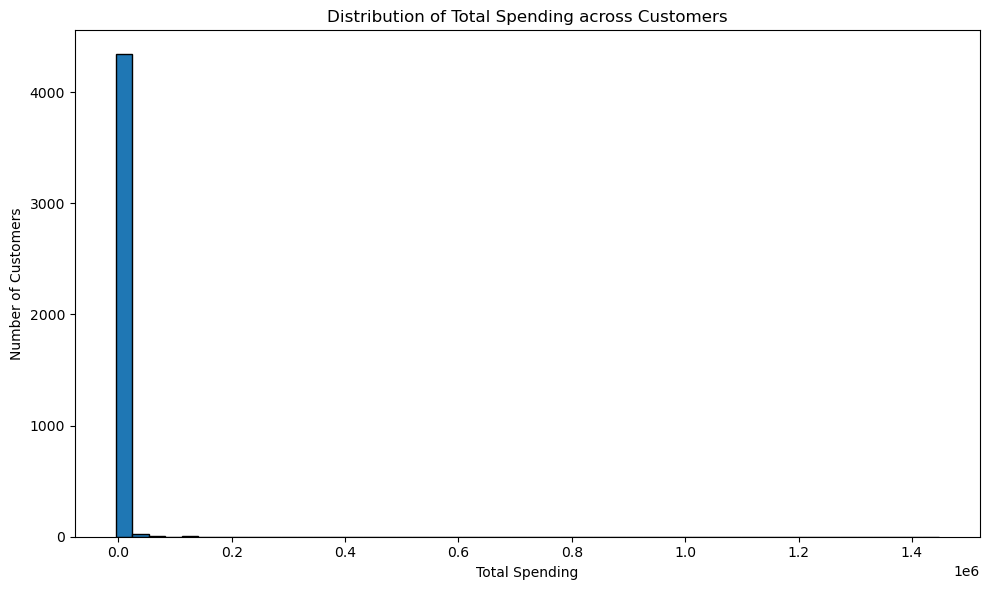

In [36]:
plt.figure(figsize=(10, 6))
plt.hist(total_spending_sorted['TotalSales'], bins=50, edgecolor='k')
plt.xlabel('Total Spending')
plt.ylabel('Number of Customers')
plt.title('Distribution of Total Spending across Customers')
plt.tight_layout()
plt.show()


In [38]:
print(total_spending_sorted['TotalSales'].describe())


count    4.373000e+03
mean     2.224104e+03
std      2.335391e+04
min     -4.287630e+03
25%      2.918800e+02
50%      6.442400e+02
75%      1.610150e+03
max      1.447488e+06
Name: TotalSales, dtype: float64


Recency of purchase 

In [39]:

data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

# Determine the latest date in the dataset
latest_date = data['InvoiceDate'].max()

# Determine the most recent purchase date for each customer
recency = data.groupby('CustomerID')['InvoiceDate'].max().reset_index()

# Calculate recency in terms of number of days since last purchase
recency['Recency'] = (latest_date - recency['InvoiceDate']).dt.days

# Sort customers by recency
recency_sorted = recency.sort_values(by='Recency', ascending=True)

# Display the top 10 customers with the most recent purchases
print(recency_sorted.tail(10))


     CustomerID         InvoiceDate  Recency
1405    14237.0 2010-12-01 13:20:00      372
4107    17925.0 2010-12-02 10:10:00      372
1334    14142.0 2010-12-01 16:33:00      372
4140    17968.0 2010-12-01 12:23:00      373
1046    13747.0 2010-12-01 10:37:00      373
3129    16583.0 2010-12-01 12:03:00      373
1764    14729.0 2010-12-01 12:43:00      373
4096    17908.0 2010-12-01 11:45:00      373
4212    18074.0 2010-12-01 09:53:00      373
359     12791.0 2010-12-01 11:27:00      373


average basket size

In [40]:
# Calculate total items for each order
order_totals = data.groupby('InvoiceNo')['Quantity'].sum().reset_index()

# Calculate average basket size
average_basket_size = order_totals['Quantity'].mean()

print(f"Average Basket Size: {average_basket_size:.2f} items")


Average Basket Size: 199.32 items


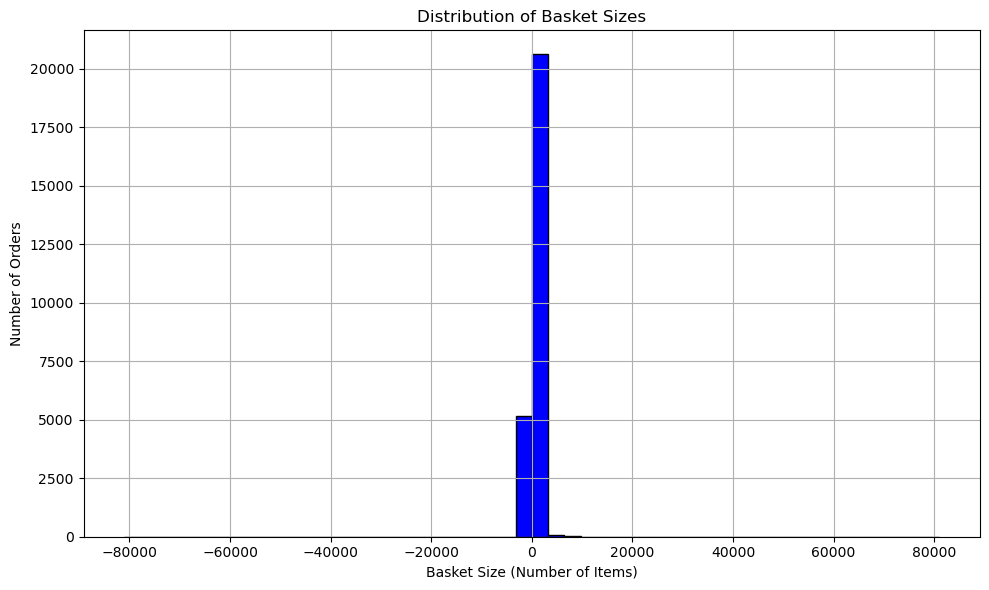

In [41]:
#distribution of basket sizes
plt.figure(figsize=(10, 6))
plt.hist(order_totals['Quantity'], bins=50, color='blue', edgecolor='black')
plt.title('Distribution of Basket Sizes')
plt.xlabel('Basket Size (Number of Items)')
plt.ylabel('Number of Orders')
plt.grid(True)
plt.tight_layout()
plt.show()



Scatter Plot of Quantity vs Unit Price:
This can help identify any relationship or trend between the quantity of items sold and their prices.

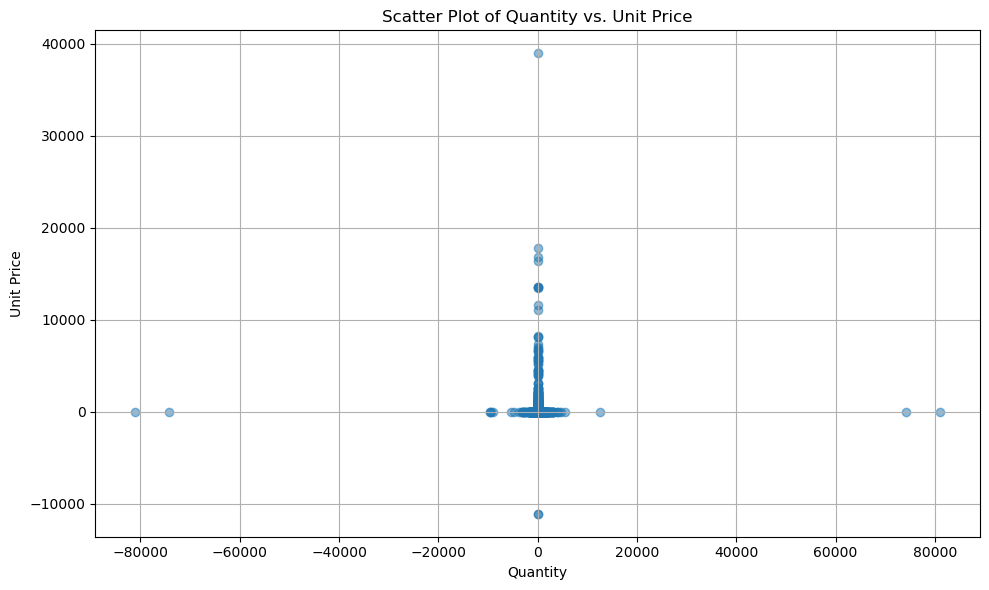

In [42]:

# Scatter Plot
plt.figure(figsize=(10,6))
plt.scatter(data['Quantity'], data['UnitPrice'], alpha=0.5)
plt.title('Scatter Plot of Quantity vs. Unit Price')
plt.xlabel('Quantity')
plt.ylabel('Unit Price')
plt.grid(True)
plt.tight_layout()
plt.show()


Sales Anomalies:
A time series plot can help spot any anomalies or unexpected spikes in sales

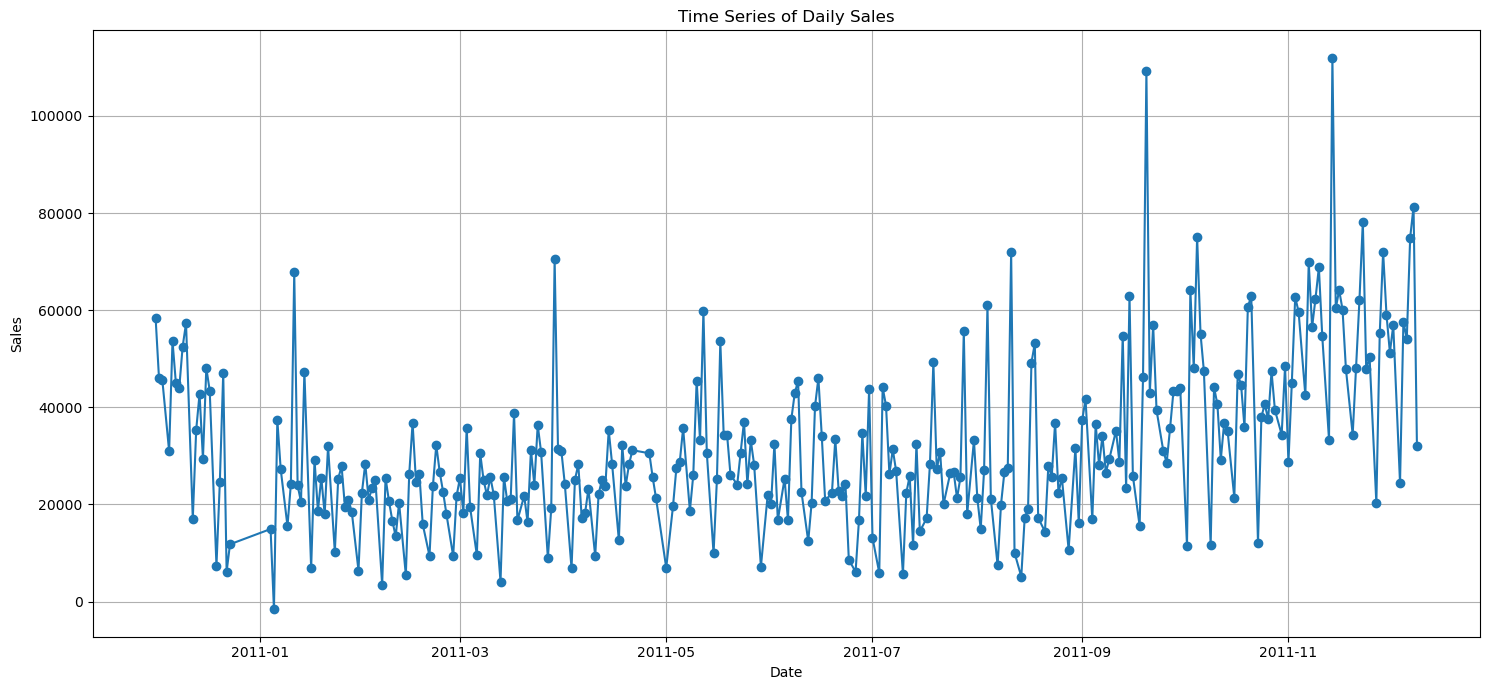

In [43]:

# Calculate total sales for each transaction
data['Sales'] = data['Quantity'] * data['UnitPrice']

# Group by InvoiceDate to get total daily sales
daily_sales = data.groupby(data['InvoiceDate'].dt.date).agg({'Sales': 'sum'}).reset_index()

# Time series plot
plt.figure(figsize=(15, 7))
plt.plot(daily_sales['InvoiceDate'], daily_sales['Sales'], marker='o', linestyle='-')
plt.title('Time Series of Daily Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.tight_layout()
plt.show()


In [44]:
data.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice CustomerID         Country  TotalSales  \
0 2010-12-01 08:26:00       2.55    17850.0  United Kingdom       15.30   
1 2010-12-01 08:26:00       3.39    17850.0  United Kingdom       20.34   
2 2010-12-01 08:26:00       2.75    17850.0  United Kingdom       22.00   
3 2010-12-01 08:26:00       3.39    17850.0  United Kingdom       20.34   
4 2010-12-01 08:26:00       3.39    17850.0  United Kingdom       20.34   

   DayOfWeek     Month  Sales  
0  Wednesday  December  15.30  
1  Wednesday  December  20.34  
2  Wednesday  December  22.00  
3  Wednesday  December  20.34  
4  Wednesday  December  20.34

In [45]:
#drop Description and CustomerID because they are not usuful 
data=data.drop(columns=['Description','CustomerID'], axis =1)
data.head()

InvoiceNo StockCode  Quantity         InvoiceDate  UnitPrice  \
0    536365    85123A         6 2010-12-01 08:26:00       2.55   
1    536365     71053         6 2010-12-01 08:26:00       3.39   
2    536365    84406B         8 2010-12-01 08:26:00       2.75   
3    536365    84029G         6 2010-12-01 08:26:00       3.39   
4    536365    84029E         6 2010-12-01 08:26:00       3.39   

          Country  TotalSales  DayOfWeek     Month  Sales  
0  United Kingdom       15.30  Wednesday  December  15.30  
1  United Kingdom       20.34  Wednesday  December  20.34  
2  United Kingdom       22.00  Wednesday  December  22.00  
3  United Kingdom       20.34  Wednesday  December  20.34  
4  United Kingdom       20.34  Wednesday  December  20.34

In [46]:
num_unique_stock_codes = data['StockCode'].nunique()
print(num_unique_stock_codes)


4070


In [47]:
#drop columns one hot encoding will be to much for StockCode and Country 
data = data.drop(columns=['InvoiceNo','StockCode','InvoiceDate','Country'], axis=1) 
data.head()

Quantity  UnitPrice  TotalSales  DayOfWeek     Month  Sales
0         6       2.55       15.30  Wednesday  December  15.30
1         6       3.39       20.34  Wednesday  December  20.34
2         8       2.75       22.00  Wednesday  December  22.00
3         6       3.39       20.34  Wednesday  December  20.34
4         6       3.39       20.34  Wednesday  December  20.34

In [48]:
data.columns

Index(['Quantity', 'UnitPrice', 'TotalSales', 'DayOfWeek', 'Month', 'Sales'], dtype='object')

In [49]:

#preprocessing

def preprocess_data(data):
    processed_data = data.copy()

    # Transforming numeric features
    scaler = StandardScaler()
    processed_data['Quantity'] = scaler.fit_transform(data['Quantity'].values.reshape(-1, 1))
    processed_data['UnitPrice'] = scaler.fit_transform(data['UnitPrice'].values.reshape(-1, 1))

    # Transforming 'Month' ordinal feature
    months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
    month_encoder = OrdinalEncoder(categories=[months])
    processed_data['Month'] = month_encoder.fit_transform(processed_data['Month'].values.reshape(-1, 1))

    # Transforming 'DayOfWeek' ordinal feature
    days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    day_encoder = OrdinalEncoder(categories=[days])
    processed_data['DayOfWeek'] = day_encoder.fit_transform(processed_data['DayOfWeek'].values.reshape(-1, 1))

   
    
   
    

    return processed_data


In [50]:
processed_data = preprocess_data(data)
print(processed_data.isna().sum())

Quantity      0
UnitPrice     0
TotalSales    0
DayOfWeek     0
Month         0
Sales         0
dtype: int64


In [51]:
#processed_data = processed_data.drop(columns=['InvoiceNo', 'StockCode'])
processed_data.head()

Quantity  UnitPrice  TotalSales  DayOfWeek  Month  Sales
0 -0.016520  -0.021419       15.30        2.0   11.0  15.30
1 -0.016520  -0.012780       20.34        2.0   11.0  20.34
2 -0.007393  -0.019362       22.00        2.0   11.0  22.00
3 -0.016520  -0.012780       20.34        2.0   11.0  20.34
4 -0.016520  -0.012780       20.34        2.0   11.0  20.34

In [52]:
#apply pca
dim_red = PCA(n_components=2)


In [53]:
x_pca=dim_red.fit_transform(processed_data)

In [54]:
x_pca

array([[ 3.99354749, -4.44115604],
       [-3.13407628, -4.44114893],
       [-5.48168451, -4.44114489],
       ...,
       [ 2.15510841, -4.49868161],
       [ 2.15510841, -4.49868161],
       [ 4.62998866, -4.49868386]])

In [55]:
x_pca.shape

(536641, 2)

In [56]:
dim_red.explained_variance_ratio_

array([9.99941744e-01, 4.25040053e-05])

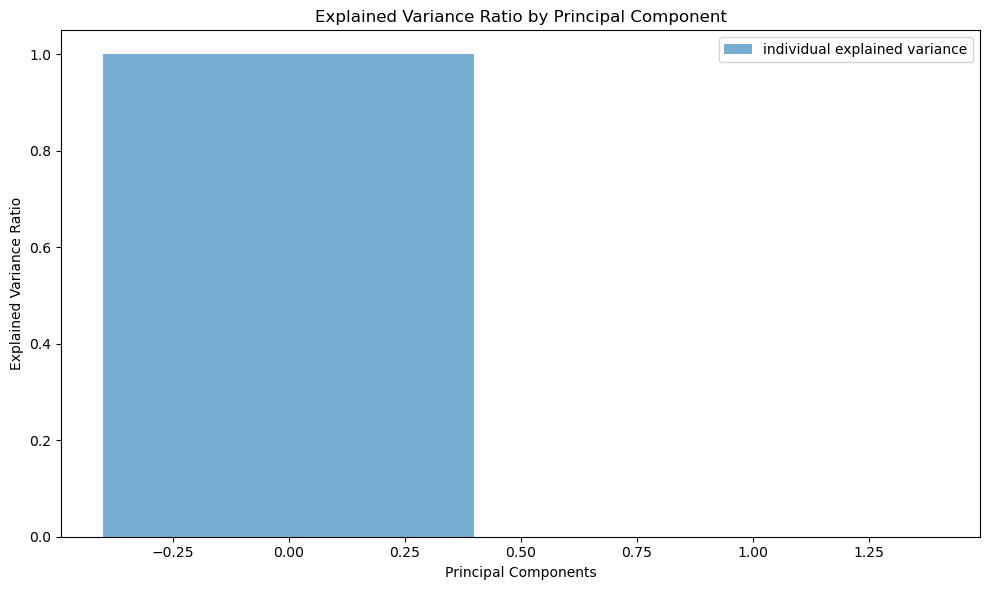

In [57]:
#show explained variance ratio
explained_variance = dim_red.explained_variance_ratio_

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(range(len(explained_variance)), explained_variance, alpha=0.6, align='center', label='individual explained variance')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.title('Explained Variance Ratio by Principal Component')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


In [58]:
dim_red.get_feature_names_out()

array(['pca0', 'pca1'], dtype=object)

In [59]:
df_pca=pd.DataFrame(x_pca, columns=dim_red.get_feature_names_out())
df_pca.head()

pca0      pca1
0  3.993547 -4.441156
1 -3.134076 -4.441149
2 -5.481685 -4.441145
3 -3.134076 -4.441149
4 -3.134076 -4.441149

C:\Users\Khadi\.conda\envs\new\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\Khadi\.conda\envs\new\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\Khadi\.conda\envs\new\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\Khadi\.conda\envs\new\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



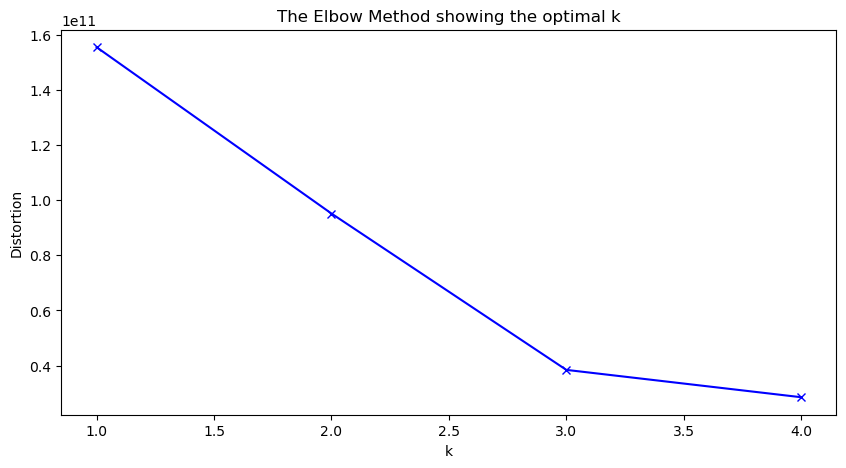

In [60]:
#find the best number of clusters
# Elbow method
distortions = []
K = range(1,5)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(processed_data)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(10,5))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()




C:\Users\Khadi\.conda\envs\new\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



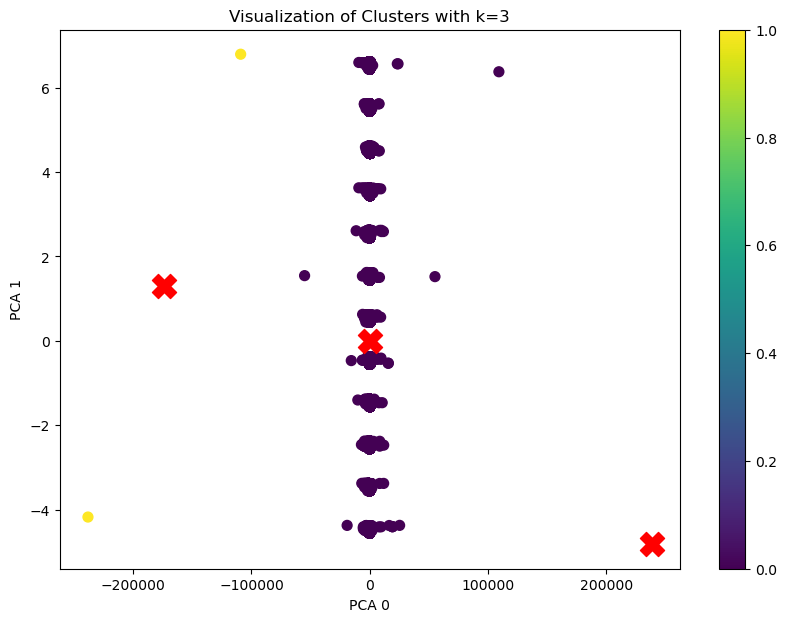

In [61]:
# Instantiate the model with optimal k
kmeans_optimal = KMeans(n_clusters=3)
kmeans_optimal.fit(df_pca)

# Plot
plt.figure(figsize=(10,7))
plt.scatter(df_pca['pca0'], df_pca['pca1'], c=kmeans_optimal.labels_, cmap='viridis', s=50)
plt.scatter(kmeans_optimal.cluster_centers_[:, 0], kmeans_optimal.cluster_centers_[:, 1], s=300, c='red', marker='X')
plt.xlabel("PCA 0")
plt.ylabel("PCA 1")
plt.title("Visualization of Clusters with k=3")
plt.colorbar()
plt.show()


Assign Cluster Labels to Original Data

In [62]:
data['Cluster'] = kmeans_optimal.labels_


Aggregate Data by Cluster

In [63]:
cluster_summary = data.groupby('Cluster').agg({
    'Quantity': ['mean', 'sum'],
    'UnitPrice': ['mean', 'max', 'min'],
    'TotalSales': ['mean', 'sum'],
   
}).reset_index()


Profile

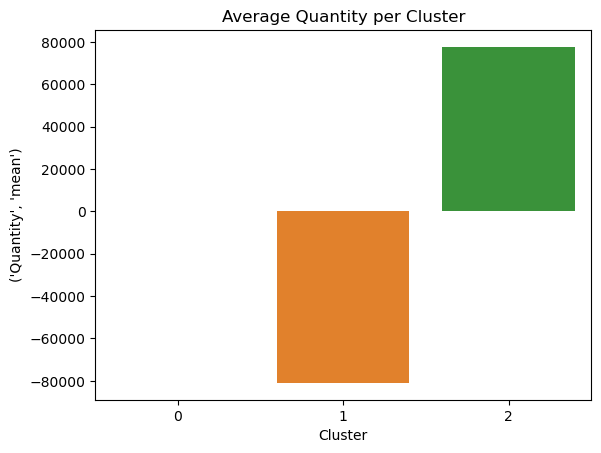

In [64]:


# Bar plot of average quantity per cluster
sns.barplot(x='Cluster', y=('Quantity', 'mean'), data=cluster_summary)
plt.title('Average Quantity per Cluster')
plt.show()


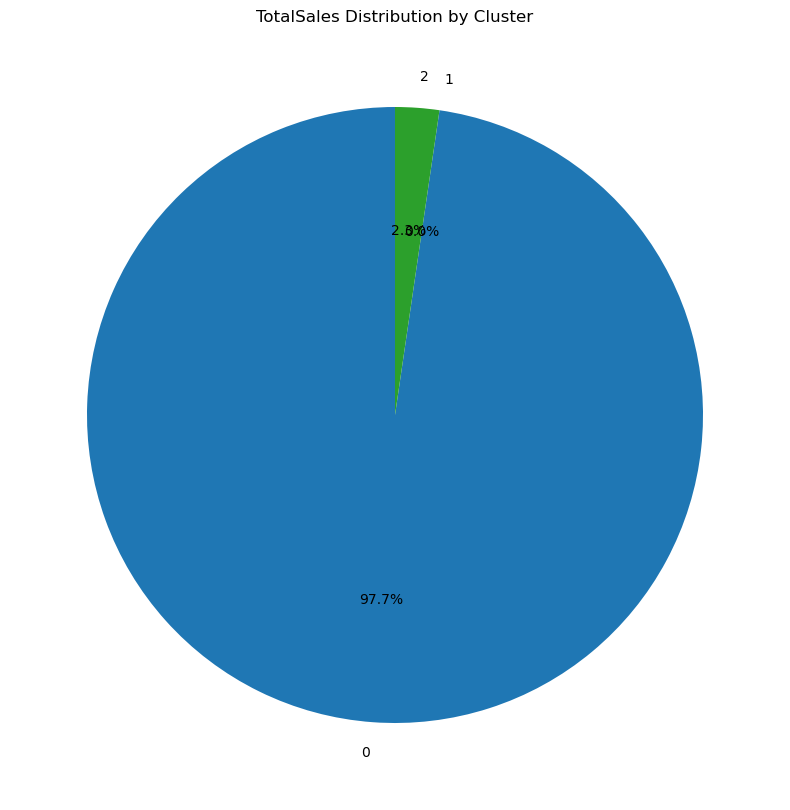

In [65]:
# Adjusting negative sales
data['TotalSales'] = data['TotalSales'].apply(lambda x: max(0, x))

# Aggregating sales by cluster
sales_by_cluster = data.groupby('Cluster')['TotalSales'].sum()

# Plotting the pie chart
plt.figure(figsize=(10,10))
plt.pie(sales_by_cluster, labels=sales_by_cluster.index, autopct='%1.1f%%', startangle=90)
plt.title('TotalSales Distribution by Cluster')
plt.show()


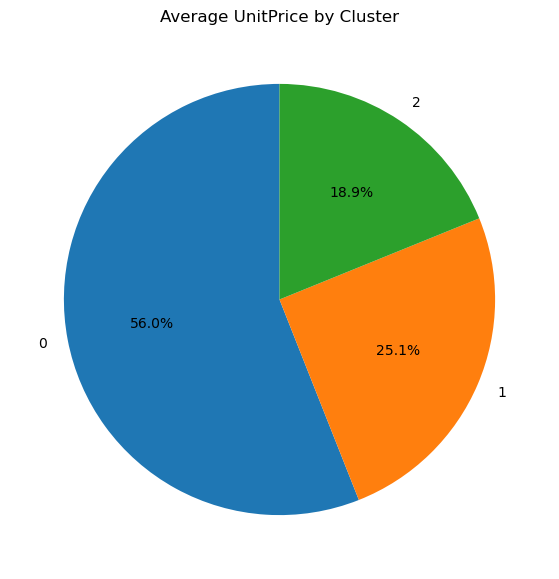

In [66]:
# Aggregating average unit price by cluster
average_unit_price_by_cluster = data.groupby('Cluster')['UnitPrice'].mean()

# Plotting the pie chart
plt.figure(figsize=(10,7))
plt.pie(average_unit_price_by_cluster, labels=average_unit_price_by_cluster.index, autopct='%1.1f%%', startangle=90)
plt.title('Average UnitPrice by Cluster')
plt.show()


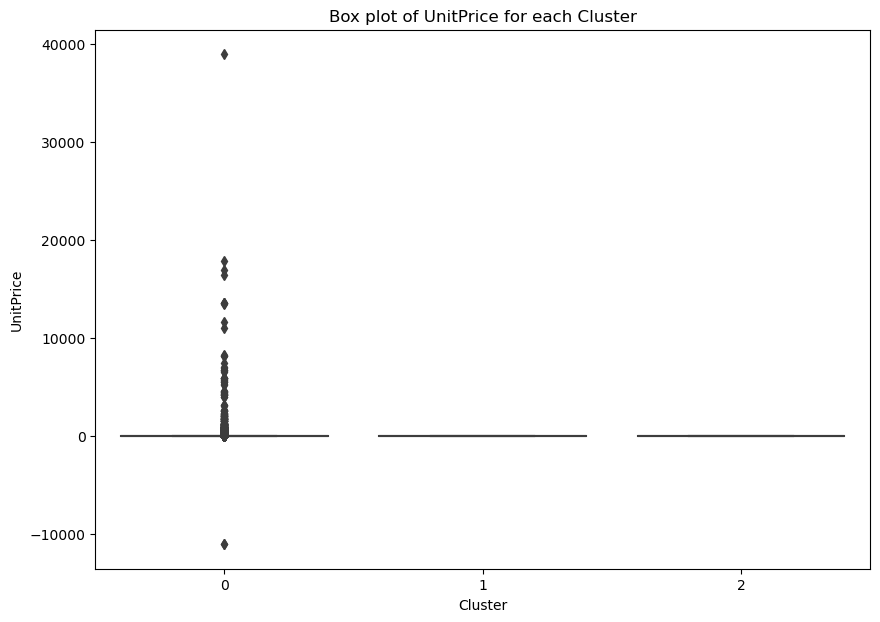

In [69]:
plt.figure(figsize=(10, 7))
sns.boxplot(x='Cluster', y='UnitPrice', data=data)
plt.title('Box plot of UnitPrice for each Cluster')
plt.show()


C:\Users\Khadi\AppData\Local\Temp\ipykernel_15356\1201998026.py:2: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



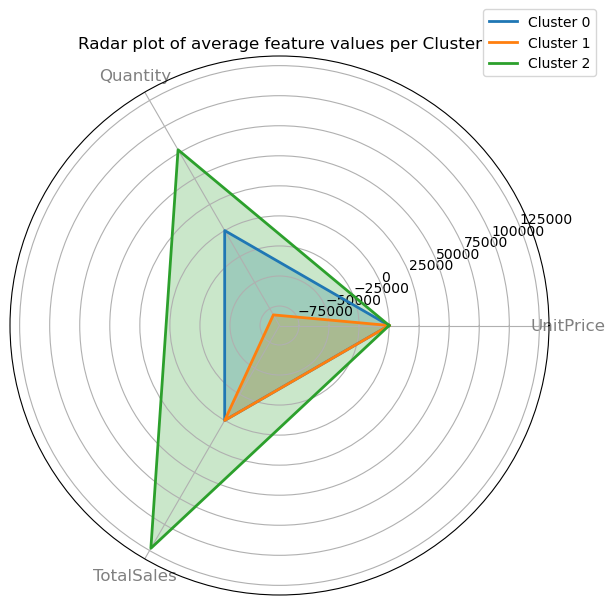

In [70]:

# Compute the mean of each feature for each cluster
cluster_means = data.groupby('Cluster').mean().reset_index()

# List of features to compare
features = ['UnitPrice', 'Quantity', 'TotalSales']

# Number of variables we're plotting.
num_vars = len(features)

angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
angles += angles[:1]

# Set the figure
plt.figure(figsize=(10, 7))
ax = plt.subplot(111, polar=True)

# Draw one axe per variable + add labels
plt.xticks(angles[:-1], features, color='grey', size=12)

# Draw values for each cluster
for cluster in cluster_means['Cluster'].unique():
    values = cluster_means[cluster_means['Cluster'] == cluster][features].values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=f"Cluster {cluster}")
    ax.fill(angles, values, alpha=0.25)

# Add a title and legend
plt.title('Radar plot of average feature values per Cluster')
ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
plt.show()


Silhouette Score:
The silhouette score measures how close each point in one cluster is to the points in the neighboring clusters. Its values range from -1 to 1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters.

In [ ]:
#Silhouette Score
silhouette_avg = silhouette_score(df_pca, kmeans_optimal.labels_)
print(f"Silhouette Score: {silhouette_avg}")


Within-Cluster Sum of Squares (WCSS):

In [71]:
# Print the WCSS for the current cluster solution
print(f"WCSS for {kmeans_optimal.n_clusters} clusters: {kmeans_optimal.inertia_}")


WCSS for 3 clusters: 38420147246.59299


# Interpretation:
Cluster 1 is Vital for Revenue: Despite their average unit price being lower than Cluster 0, they are the backbone of the business in terms of sales revenue. Strategies should be in place to retain and further engage this segment.

Diversify Offerings for Cluster 0 and 2: Given their lower contribution to total sales, there might be an opportunity to engage these customers more. Special promotions, targeted marketing, or diversifying product offerings might help in increasing their purchase frequency or volume.

Understand Purchase Behavior: Delve deeper into the purchase behavior of each cluster. For instance, Cluster 1, despite a lower average price point, contributes massively to sales. Do they buy in bulk? Are they wholesale customers or businesses? On the other hand, why do Cluster 0 and 2 purchase less frequently?

Tailor Marketing Strategies: With these insights, personalized marketing and sales strategies can be developed for each cluster. Cluster 1 might appreciate loyalty programs or bulk-buy discounts, while Cluster 0 and 2 might be more responsive to occasional sales or new product launches.





